<a href="https://colab.research.google.com/github/gaussssss/machinelearning-tpe/blob/main/Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##BOOSTING À PARTIR DE ZÉRO AVEC PYTHON


In [ ]:
"""
Create a Decision Stump
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import scipy.stats as sps
from google.colab import drive
drive.mount('/content/drive/')
data_path = "/content/drive/MyDrive/Colab Notebooks/random_forest/"
dataset = pd.read_csv(data_path+'agaricus-lepiota.data',header=None)


Mounted at /content/drive/


In [ ]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [ ]:
# Charger les données et définir les étiquettes des colonnes
dataset = pd.read_csv(data_path+'agaricus-lepiota.data',header=None)
dataset = dataset.sample(frac=1)
dataset.columns = ['target','cap-shape','cap-surface','cap-color','bruises',
                   'odor','gill-attachment','gill-spacing',
'gill-size','gill-color','stalk-shape','stalk-root',
'stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring',
'stalk-color-below-ring','veil-type','veil-color',
'ring-number','ring-type','spore-print-color','population',
'habitat']
# Encodez les valeurs des caractéristiques des chaînes en nombres entiers puisque le sklearn DecisionTreeClassifier ne prend que des valeurs numériques
for label in dataset.columns:
  dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label]) #Encodez les étiquettes cibles avec une valeur comprise entre 0 et n_classes-1
Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1)
X = dataset.drop('target',axis=1)
Y = dataset['target'].where(dataset['target']==1,-1)
predictions = np.mean(cross_validate(Tree_model,X,Y,cv=100)['test_score']) #utilisation de la validation croisée d'ordre 100
print('The accuracy is: ',predictions*100,'%')


The accuracy is:  73.06790123456791 %


criterion:La fonction pour mesurer la qualité d'une division.
max_depth:La profondeur maximale de l'arbre
entropy:mésure pour déterminer le gain d'information

With a number of  50 base models we receive an accuracy of  98.67060561299851 %


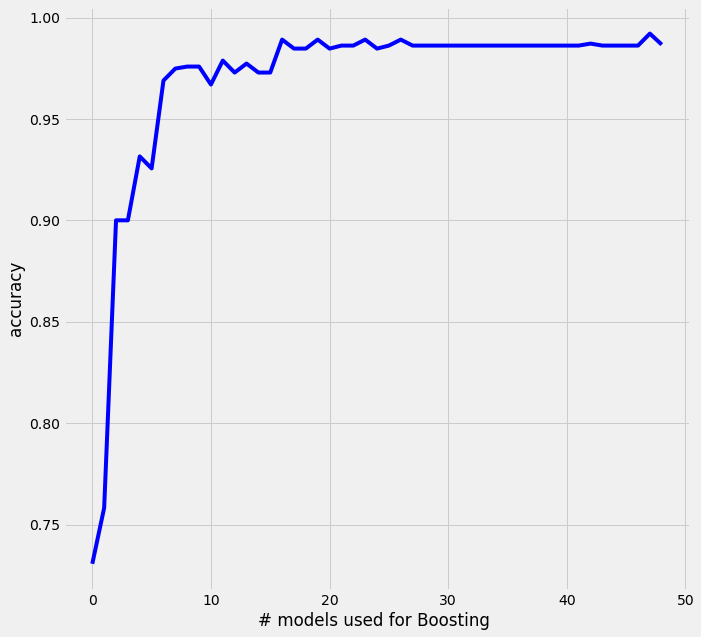

In [ ]:
class Boosting:
  def __init__(self,dataset,T,test_dataset):
    self.dataset = dataset
    self.T = T
    self.test_dataset = test_dataset
    self.alphas = None
    self.models = None
    self.accuracy = []
    self.predictions = None
  def fit(self):
    # Définissez les caractéristiques descriptives et la caractéristique cible
    X = self.dataset.drop(['target'],axis=1)
    Y = self.dataset['target'].where(self.dataset['target']==1,-1)
    # Initialiser les poids de chaque échantillon avec wi = 1/N et créer une base de données dans laquelle l'évaluation est calculée
    Evaluation = pd.DataFrame(Y.copy())
    Evaluation['weights'] = 1/len(self.dataset) # Définir les poids initiaux w = 1/N
    # Exécutez l'algorithme de boosting en créant T "modèles pondérés"
    alphas = []
    models = []
    for t in range(self.T):
    # Former le(s) support(s) de décision
      Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1) 
      # Mind the deth one --> Decision Stump
    # Nous savons que nous devons former nos souches de décision sur des ensembles de données pondérés où les poids dépendent des résultats de
     # les souches de décision précédentes. Pour ce faire, nous utilisons la colonne "pondérations" de la création ci-dessus
     # 'evaluation dataframe' avec le paramètre sample_weight de la méthode d'ajustement.
     # La documentation pour le paramètre sample_weights dit : "[...] Si aucun, alors les échantillons sont pondérés de manière égale."
     # Par conséquent, si PAS Aucun, alors les échantillons ne sont PAS pondérés de manière égale et nous créons ainsi un ensemble de données PONDÉRÉ
     # qui est exactement ce que nous voulons avoir.
      model = Tree_model.fit(X,Y,sample_weight=np.array(Evaluation['weights']))
    # Ajoutez les classificateurs faibles simples à une liste qui est ensuite utilisée pour faire le
     # décision pondérée
      models.append(model)
      predictions = model.predict(X)
      score = model.score(X,Y)
    # Ajouter des valeurs au DataFrame d'évaluation
      Evaluation['predictions'] = predictions
      Evaluation['evaluation'] = np.where(Evaluation['predictions'] == Evaluation['target'],1,0)
      Evaluation['misclassified'] = np.where(Evaluation['predictions'] != Evaluation['target'],1,0)
    # Calculer le taux et la précision des erreurs de classification
      accuracy = sum(Evaluation['evaluation'])/len(Evaluation['evaluation'])
      misclassification = sum(Evaluation['misclassified'])/len(Evaluation['misclassified'])
    # Calculer l'erreur
      err = np.sum(Evaluation['weights']*Evaluation['misclassified'])/np.sum(Evaluation['weights'])
    # Calculer les valeurs alpha
      alpha = np.log((1-err)/err)
      alphas.append(alpha)
    # Mettre à jour les poids wi --> Ces poids mis à jour sont utilisés dans le paramètre sample_weight
     # pour la formation de la prochaine souche de décision.
      Evaluation['weights'] *= np.exp(alpha*Evaluation['misclassified'])
    #print('The Accuracy of the {0}. model is : '.format(t+1),accuracy*100,'%')
    #print('The missclassification rate is: ',misclassification*100,'%')
    self.alphas = alphas
    self.models = models
  def predict(self):
    X_test = self.test_dataset.drop(['target'],axis=1).reindex(range(len(self.test_dataset)))
    Y_test = self.test_dataset['target'].reindex(range(len(self.test_dataset))).where(self.dataset['target']==1,-1)
    #La fonction numpy.where() renvoie les indices des éléments dans un tableau d'entrée où la condition donnée est satisfaite.
    # Avec chaque modèle de la liste self.model, faites une prédiction
    accuracy = []
    predictions = []
    for alpha,model in zip(self.alphas,self.models):
      prediction = alpha*model.predict(X_test) # Nous utilisons la méthode de prédiction pour les modèles de classement d'arbre de décision unique dans la liste
      predictions.append(prediction)
      self.accuracy.append(np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0]))
      # La ligne de code ci-dessus pourrait être un peu déroutante et je vais donc suivre les étapes simples :
      # Objectif : Créer une liste de précisions qui peuvent être utilisées pour tracer la précision par rapport au nombre d'apprenants de base utilisés pour le modèle
      # 1. np.array(predictions) --> C'est le tableau qui contient les prédictions des modèles individuels. Il a la forme 8124xn
      # et ressemble donc à [[0.998,0.87,...0.87...],[...],[...],[0.99,1.23,...,1.05,0,99...] ]
      # 2. np.sum(np.array(predictions),axis=0) --> Résume les premiers éléments des listes, soit 0,998+...+...+0.99. C'est
      # terminé puisque la formule de prédiction veut que nous résumions les prédictions de tous les modèles pour chaque instance de l'ensemble de données.
      # Par conséquent, si nous avons par exemple 3 modèles, le tableau des prédictions a la forme 8124x3 (Imaginez un tableau avec 3 colonnes et
      # 8124 lignes). Ici, la première colonne contient les prédictions pour le premier modèle, la deuxième colonne contient les
      # prédiction pour le deuxième modèle, la troisième colonne la prédiction pour le troisième modèle (n'oubliez pas que le
      # le deuxième et le troisième modèle sont influencés par les résultats du premier respectivement le premier et le
      # deuxième modèle). C'est logique puisque les résultats de la colonne (modèle)
      # n-1 sont utilisés pour modifier les poids du nième modèle et les résultats du nième modèle sont ensuite utilisés pour modifier les poids
      # du modèle n+1.
      # 3. np.sign(np.sum(np.array(predictions),axis=0)) --> Puisque nos données cibles de test sont des éléments de {-1,1} et que nous voulons
      # avons notre prédiction dans le même format, nous utilisons la fonction signe. Par conséquent, chaque colonne du tableau de précision est comme
      # [-0.998,1.002,1.24,...,-0.89] et chaque élément représente la prédiction combinée et pondérée de tous les modèles jusqu'à cette colonne
      # (donc si nous sommes par exemple dans la 5ème colonne et pour la 4ème instance nous trouvons la valeur -0.989, cette valeur représente la
      # prédiction pondérée d'un modèle boosté avec 5 apprenants de base pour la 4ème instance. La 4ème instance de la 6ème colonne représente
      # les prédictions pondérées et combinées d'un modèle boosté avec 6 apprenants de base tandis que la 4ème instance de la 4ème colonne représente
      # la prédiction d'un modèle avec 4 apprenants de base et ainsi de suite...). Pour faire court, nous nous intéressons aux
      # le signe de ces prédictions combinées. Si le signe est positif, nous savons que la vraie prédiction est plus probablement positive (1) alors
      # négatif (-1). Plus la valeur (positive ou négative) est élevée, plus il est probable que le modèle renvoie la prédiction correcte.
      # 4. np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0]) --> Avec la dernière étape nous avons transformé le tableau
      # dans la forme 8124x1 où les instances sont des éléments {-1,1} et nous sommes maintenant dans la situation de comparer ceci
      # prédiction avec nos valeurs de caractéristiques cibles. Le tableau d'entités cible est de la forme 8124x1 puisque pour chaque ligne qu'il contient
      # exactement une prédiction {-1,1} tout comme notre tableau que nous venons de créer ci-dessus --> Prêt à comparer ;).
      # La comparaison se fait avec la commande == Y_test.values. Comme résultat on obtient un
      # tableau de la forme 8124x1 où les instances sont des éléments de {True,False} (True si notre prédiction est cohérente avec la
      # valeur de la caractéristique cible et False sinon). Puisque nous voulons calculer une valeur en pourcentage, nous devons calculer la fraction de
      # instances correctement classées. Par conséquent, nous résumons simplement le tableau de comparaison ci-dessus
      # avec les éléments {True,False} le long de l'axe 0.
      # et divisez-le par le nombre total de lignes (8124) puisque True est égal à 1 et False est égal à 0. D'où des prédictions correctes
      # augmenter la somme alors que les fausses prédictions ne changent pas la somme. Si nous n'avons rien prédit, corrigez le calcul en 0/8124 et
      # avec 0 et si nous avons tout prédit correctement, le calcul est 8124/8124 et donc 1.
      # 5. self.accuracy.append(np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0])) -- >
      # Après avoir calculé les étapes ci-dessus, nous ajoutons le résultat à la liste self.accuracy. Cette liste a la forme n x 1, c'est-à-dire
      # pour un modèle avec 5 apprenants de base, cette liste a 5 entrées où la 5ème entrée représente la précision du modèle lorsque tous
      # 5 apprenants de base sont combinés, le 4ème élément la précision du modèle lorsque 4 apprenants de base sont combinés et ainsi de suite. Cette
      # la procédure a été expliquée ci-dessus. C'est tout et nous pouvons tracer la précision.
    self.predictions = np.sign(np.sum(np.array(predictions),axis=0))

######Plot the accuracy of the model against the number of stump-models used##########
number_of_base_learners = 50
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
for i in range(number_of_base_learners):
  model = Boosting(dataset,i,dataset)
  model.fit()
  model.predict()
ax0.plot(range(len(model.accuracy)),model.accuracy,'-b')
ax0.set_xlabel('# models used for Boosting ')
ax0.set_ylabel('accuracy')
print('With a number of ',number_of_base_learners,'base models we receive an accuracy of ',model.accuracy[-1]*100,'%')
plt.show()




##BOOSTING USING SKLEARN

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
for label in dataset.columns:
  dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])
X = dataset.drop(['target'],axis=1)
Y = dataset['target']
#model = DecisionTreeClassifier(criterion='entropy',max_depth=1)
#AdaBoost = AdaBoostClassifier(base_estimator= model,n_estimators=400,learning_rate=1)
AdaBoost = AdaBoostClassifier(n_estimators=400,learning_rate=1,algorithm='SAMME')
AdaBoost.fit(X,Y)
prediction = AdaBoost.score(X,Y)
print('The accuracy is: ',prediction*100,'%')


The accuracy is:  100.0 %


##Paramètre du classifieur Adaboost
objet base_estimator , par défaut=Aucun:
L'estimateur de base à partir duquel l'ensemble boosté est construit. La prise en charge de la pondération de l'échantillon est requise, ainsi que des attributs classes_et des n_classes_attributs appropriés. Si None, alors l'estimateur de base est DecisionTreeClassifier initialisé avec max_depth=1.

n_estimators int, par défaut=50:
Le nombre maximal d'estimateurs auquel l'amplification est terminée. En cas d'ajustement parfait, la procédure d'apprentissage est arrêtée prématurément. Les valeurs doivent être comprises dans la plage [1, inf).

flottant du taux d'apprentissage , par défaut = 1,0:
Pondération appliquée à chaque classifieur à chaque itération de boosting. Un taux d'apprentissage plus élevé augmente la contribution de chaque classifieur. Il existe un compromis entre les paramètres learning_rateet . n_estimatorsLes valeurs doivent être comprises dans la plage (0.0, inf).

algorithme {'SAMME', 'SAMME.R'}, default='SAMME.R':
Si 'SAMME.R', utilisez l'algorithme de boost réel SAMME.R. base_estimatordoit prendre en charge le calcul des probabilités de classe. Si 'SAMME', utilisez l'algorithme d'amplification discrète SAMME. L'algorithme SAMME.R converge généralement plus rapidement que SAMME, obtenant une erreur de test inférieure avec moins d'itérations de boosting.

random_state int, instance RandomState ou None, default=None. 